In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import itertools
import statsmodels.api as sm
import torch
import torch.nn as nn

import statsmodels.api as sm

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [0]:
train = pd.read_csv('/content/drive/My Drive/Prophet_train.csv')
train.columns = ['GrocerySales','DS']
train.head()

,GrocerySales,DS
0,8418.59,2018-01-01
1,8447.47,2018-01-02
2,8336.49,2018-01-03
3,8579.17,2018-01-04
4,8524.31,2018-01-05


In [0]:
sm.tsa.seasonal_decompose(train.GrocerSales).plot()
result = sm.tsa.stattools.adfuller(train.GrocerySales)
plt.show()

In [0]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

# Courtesy: Code has been replicated and similar to MachineLearning Mastery by Brownlee. Thanks for these helper functions

# Data Preparation

In [0]:
from sklearn.preprocessing import MinMaxScaler
all_data = train.GrocerySales.values.astype(float)

test_data_size = 100

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

train_window = 12
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)


# LSTM trained on 12 window

In [0]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=20, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [0]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTM(
  (lstm): LSTM(1, 20)
  (linear): Linear(in_features=20, out_features=1, bias=True)
)


In [0]:
epochs = 3000
from sklearn.metrics import mean_squared_error
minimum = np.inf
for i in range(epochs):
    loss = 0
    for seq, labels in train_inout_seq:
      optimizer.zero_grad()
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                      torch.zeros(1, 1, model.hidden_layer_size))

      y_pred = model(seq)
      loss += mean_squared_error(scaler.inverse_transform(labels[0].reshape(-1,1)),\
                                  scaler.inverse_transform(y_pred[0].detach().reshape(-1,1)))
      single_loss = loss_function(y_pred, labels)
      single_loss.backward()
      optimizer.step()
    if loss < minimum:
      minimum = loss
      final_model_1 = model
    
    print('epoch: {},loss : {}'.format(i,loss/580))

epoch: 0,loss : 110210.90609040888
epoch: 1,loss : 66315.35866907786
epoch: 2,loss : 54622.18896951352
epoch: 3,loss : 50548.659842624525
epoch: 4,loss : 48846.89035793945
epoch: 5,loss : 47957.360083095075
epoch: 6,loss : 47413.671328655095
epoch: 7,loss : 47042.48676290152
epoch: 8,loss : 46769.31026794613
epoch: 9,loss : 46555.14001370311
epoch: 10,loss : 46377.901870264956
epoch: 11,loss : 46226.42094558315
epoch: 12,loss : 46094.87158188636
epoch: 13,loss : 45979.52973723722
epoch: 14,loss : 45877.67164445935
epoch: 15,loss : 45787.25706851503
epoch: 16,loss : 45706.67869905605
epoch: 17,loss : 45634.51252422383
epoch: 18,loss : 45569.28202115528
epoch: 19,loss : 45509.4272260206
epoch: 20,loss : 45453.50521871839
epoch: 21,loss : 45400.057216432986
epoch: 22,loss : 45347.30278369623
epoch: 23,loss : 45292.67867870743
epoch: 24,loss : 45232.089830480574
epoch: 25,loss : 45158.20891808573
epoch: 26,loss : 45055.11629224593
epoch: 27,loss : 44867.04907355876
epoch: 28,loss : 44348.0

KeyboardInterrupt: ignored

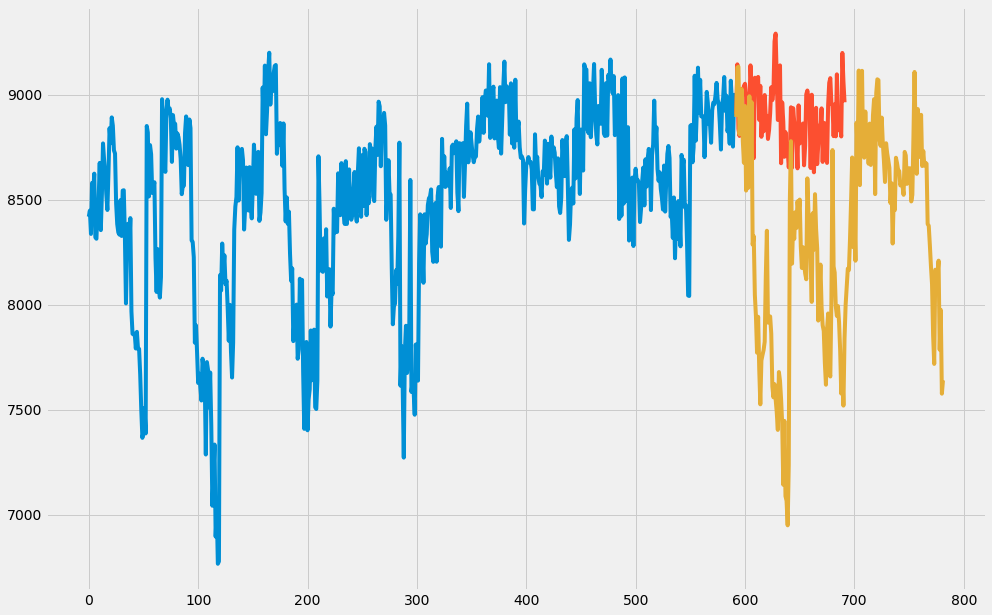

In [0]:
fut_pred = 100 + 90

test_inputs = train_data_normalized[-train_window:].tolist()

model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))

plt.figure(figsize = (15,10))
plt.plot(range(len(train_data)),train_data)
plt.plot(range(len(train_data), len(train_data) + 100), test_data)
plt.plot(range(len(train_data), len(train_data) + 100+90), actual_predictions)

In [0]:
sub = pd.DataFrame(columns = ['GrocerySales'])
merged = list(itertools.chain(*actual_predictions[-90:]))
sub['GrocerySales'] = merged
sub.to_excel('Submission_10.xlsx',index=False)

# Cutting out data(First 300 days has lot of dip) 

In [0]:
all_data = train.GrocerySales.values.astype(float)

test_data_size = 100

train_data = all_data[310:-test_data_size]
test_data = all_data[-test_data_size:]

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

train_window = 12
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

# LSTM with 12 lags

In [0]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=10, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [0]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
print(model)

LSTM(
  (lstm): LSTM(1, 10)
  (linear): Linear(in_features=10, out_features=1, bias=True)
)


In [0]:
epochs = 3000
from sklearn.metrics import mean_squared_error
minimum = np.inf
for i in range(epochs):
    loss = 0
    for seq, labels in train_inout_seq:
      optimizer.zero_grad()
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                      torch.zeros(1, 1, model.hidden_layer_size))

      y_pred = model(seq)
      loss += mean_squared_error(scaler.inverse_transform(labels[0].reshape(-1,1)),\
                                  scaler.inverse_transform(y_pred[0].detach().reshape(-1,1)))
      single_loss = loss_function(y_pred, labels)
      single_loss.backward()
      optimizer.step()
    if loss < minimum:
      minimum = loss
      final_model_4 = model
    
    print('epoch: {},loss : {}'.format(i,loss/270))

epoch: 0,loss : 8129.149915554944
epoch: 1,loss : 8141.132278785546
epoch: 2,loss : 8122.81365291639
epoch: 3,loss : 8105.980557290622
epoch: 4,loss : 8098.698813564356
epoch: 5,loss : 8067.848536872369
epoch: 6,loss : 8074.394072309248
epoch: 7,loss : 8064.6472580672
epoch: 8,loss : 8023.164998750042
epoch: 9,loss : 7998.1505365859975
epoch: 10,loss : 8032.35345449805
epoch: 11,loss : 8023.928132716363
epoch: 12,loss : 7990.235816012356
epoch: 13,loss : 7994.08856519369
epoch: 14,loss : 8060.963396113306
epoch: 15,loss : 8145.614050836195
epoch: 16,loss : 8113.18467461145
epoch: 17,loss : 8090.885749168594
epoch: 18,loss : 8063.7855257466035
epoch: 19,loss : 8051.024444426146
epoch: 20,loss : 8004.295860066885
epoch: 21,loss : 7963.540446890343
epoch: 22,loss : 7959.98318948148
epoch: 23,loss : 7981.141961672973
epoch: 24,loss : 7962.420828131578
epoch: 25,loss : 7939.785999702032
epoch: 26,loss : 7981.275477695837
epoch: 27,loss : 8036.057515416208
epoch: 28,loss : 8048.9725755675645

# Forecasting Stage

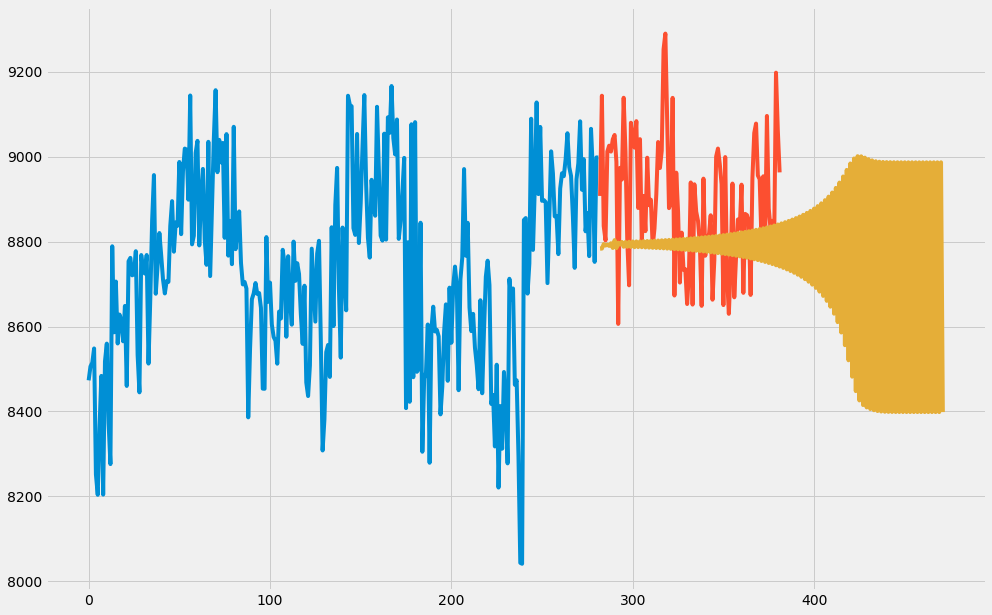

In [0]:
fut_pred = 100 + 90

test_inputs = train_data_normalized[-train_window:].tolist()

model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))

plt.figure(figsize = (15,10))
plt.plot(range(len(train_data)),train_data)
plt.plot(range(len(train_data), len(train_data) + 100), test_data)
plt.plot(range(len(train_data), len(train_data) + 100+90), actual_predictions)

In [0]:
sub = pd.DataFrame(columns = ['GrocerySales'])
merged = list(itertools.chain(*actual_predictions[-90:]))
sub['GrocerySales'] = merged
sub.to_excel('Submission_11.xlsx',index=False)

# Conclusion

1. Results are not promising, you need to train alot to get the smooth curve to fit. But the data points are just 600, so in this case it failed to perform bad. 
2. Note that **LSTM can capture long-term dependencies, so if you have large amount of data. Try doing with LSTM** and GRU's
3. Most likely for huge data, RNN's perform better than boosting algorithms
4. The other notebook in this repo has the best solution for this hackathon, which gave **4th rank in final leaderboard.**